# Trading Market Simulator (TMS)
TMS lets you experiment trading strategies and algorithms on stocks market data, just as if it was on the real live market. Being able to simulate the live stream of market data lets you travel in time to any day of your choice as well as fast forward market data, letting you experiment with trading algorithms in seconds while testing them on days, weeks or months of market movements. With TMS you can simulate long and short positions, customizing the spreads so they match with the ones used by your preferred broker. TMS uses data from [Alpaca Broker](https://alpaca.markets), so you can simulate trades on U.S. stocks as long as they are included in Alpaca. 

The data used for the simulation has a granularity of 1 minute. With TMS you can:
- Automatically download market data for any U.S. stock of your choice (as long as it is included in Alpaca),
- Simulate a stream of live market data for any day,
- Test your trading algorithms and strategies in a simple environment, but as close as possible to the real environment on Alpaca so you can simply copy-paste your code between TMS and Alpaca,
- Customize spreads for broker: you can simulate different spreads depending on the broker you want to use (more customizations such as commissions will come soon!)

TMS is open-source software (MIT License), so you can utilize it in any project you like and modify it for your needs. Note that TMS is not associated to Alpaca in any way.

## Tutorial
In this notebook, we will see some basic usage instructions for TMS, trying to get you started as fast as possible. 

### Alpaca Account
Since TMS uses data from Alpaca, the first step is to create an Alpaca account. You can create a free account [here](https://app.alpaca.markets/signup). Once you do this, enter your dashboard and click on the top left, on "Go to Paper Account." Then generate API keys: your key id and your secret key. You will need them to initiliaze TMS. 

You can find more information about the Alpaca API and authentication [here](https://alpaca.markets/docs/api-documentation/api-v2/).

### Initializing a Broker
Once you have these credentials, you can already initialize a TMS broker. The TMS broker allows us to consume market data, simulate the live stream of data, manage different accounts and positions. 

To initiliaze the broker we also need to define the assets we want to be included into the market. These assets are stocks defined by their symbol, e.g. AAPL, GOOG or QQQ, and the spread the broker defines for them in points. In the example below, we initialize two assets: one for AAPL (Apple) and QQQ (Invesco QQQ, an ETF that follows NASDAQ) and define the spreads that eToro defines, a popular online broker (note that for QQQ, the spread is calculated as the NASDAQ100 spread divided by 40 because the QQQ value is defined as 1/40th as the NASDAQ100 index.)

Optionally, we can also define a date for the broker. The broker downloads the data for a full day, from market opening time at 9:30 NYT to 16:00 NYT. If we do not choose a date, the broker will download the data for today, which might be empty if the market has not yet opened or if its a non-working day. Here, we define the date using the Pandas datetime for September 9th, 2020. You can easily switch between days using the broker.reset(date) method, as we will see below.

In [1]:
from tms import Broker, Asset
import pandas as pd

key_id = ''
secret_key = ''
assets = [Asset('AAPL', 0.21), Asset('QQQ', 2.4/40)]
date = pd.Timestamp.now(tz='America/New_York').replace(year=2020, month=9, day=9)

broker = Broker(assets=assets, alpaca_key_id=key_id, alpaca_secret_key=secret_key, date=date)

### Opening and managing an account
Once you have defined a broker, you can start managing accounts. An account is identified by a name and it contains the following properties:
- available: amount of available cash in account, used for opening new positions.
- positions: open positions for assets, they can be long (buy) or short (sell) positions.
- history: closed positions.

An account can be initialized with the method broker.open_account(name, initial_deposit), that will create an account with available = initial_deposit and no positions or history. It is important to keep a record of the name of the account, as it will be necessary to invoke it after its creation.

In [2]:
account_name = 'my_account'
broker.open_account(name=account_name, initial_deposit=1000)

### Opening and closing positions
In order to open a position, we indicate the broker the account for which we want to open the new position, the symbol of the position, the type of position ('buy' or 'sell') and the value in cash we want to invest into the position. The position will also record other data such as opening date, opening price and units bought/sold. Optionally, we can also define a stop loss or take profit for the position (stop losses and take profits are not currently working).

We can list all the open positions for an account with the method broker.get_positions(account_name).

In [3]:
position = broker.open_position(account_name=account_name, symbol='AAPL', position_type='buy', value=500)
print('Positions for account', account_name)
for p in broker.get_positions(account_name):
    print(p.__dict__)

Positions for account my_account
{'symbol': 'AAPL', 'open_date': Timestamp('2020-09-09 09:30:00-0400', tz='America/New_York'), 'position_type': 'buy', 'open_price': 117.125, 'units': 4.268943436499466, 'sl': None, 'tp': None, 'close_price': None, 'close_date': None}


We can now check the balance of the account and see how this trade impacted it.

In [4]:
print('Account balance', broker.get_account_balance(account_name))

Account balance 500


To close a position we have two options: to get the position and close it using the method broker.close_position(account_name, position, price) or to close all of the positions related to a given symbol using the method close_positions(account_name, price). If no price is used (or price=None), then the position will be closed at the closing price of the current barset. We will use the second option, since it's easier and we only have one position at the time. We will also check the balance of the account afterwards to see how closing this position alters it.

In [5]:
closed_positions = broker.close_positions(account_name, 'AAPL')
for p in closed_positions:
    print(p.__dict__)
    
print()
print('Account balance', broker.get_account_balance(account_name))

{'symbol': 'AAPL', 'open_date': Timestamp('2020-09-09 09:30:00-0400', tz='America/New_York'), 'position_type': 'buy', 'open_price': 117.125, 'units': 4.268943436499466, 'sl': None, 'tp': None, 'close_price': 116.915, 'close_date': Timestamp('2020-09-09 09:30:00-0400', tz='America/New_York')}

Account balance 999.1035218783351


Barsets represent the price of assets in a minute and have the attributes shown below (we use the same barsets as the Alpaca Python SDK.) We can obtain the current barset with the method broker.curr_barset(). In practice, barsets are rows of a Pandas dataframe with multi-index columns, so we can access each value as barset\[asset\]\[price\], e.g., barset\['AAPL'\]\['open'\].

In [6]:
barset = broker.curr_barset()
print('full barset')
print(barset)
print()
print('accessing an asset values')
barset['AAPL']

full barset
AAPL  open        117.280
      high        117.750
      low         116.790
      close       116.915
      volume    38276.000
QQQ   open        275.480
      high        275.830
      low         275.350
      close       275.580
      volume    18858.000
Name: 2020-09-09 09:30:00-04:00, dtype: float64

accessing an asset values


open        117.280
high        117.750
low         116.790
close       116.915
volume    38276.000
Name: 2020-09-09 09:30:00-04:00, dtype: float64

### Simulating live stock market data
Now that we already know how to manage accounts and positions and about barsets, we can start trading on the stream of simulated live market data. Note that the broker loads data for a market day and simulates the data from the market opening time until the closing time of that date. We can move on to the next day by calling the method reset(date=next_day).

To move to the following minute, we invoke the method broker.next_timestep(), which returns a barset and changes the internal state of the market (in the future, this method will also call stop losses and take profits, but this has not been implemented yet.) We can visualize the market movements with the following code, displaying a candle plot for the last 30 minutes of data (no plot will be shown for the first 29 minutes.)

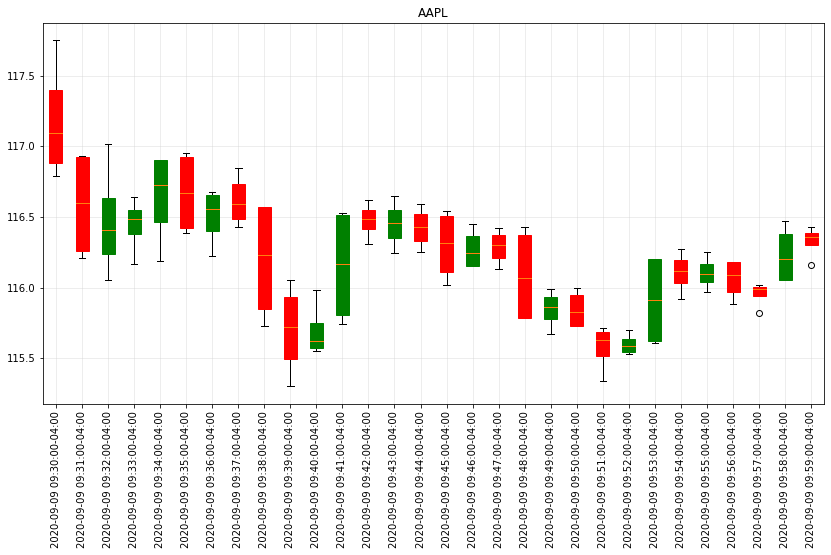

In [7]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

def plot(bar, title=None):
    df = bar[['open', 'high', 'low', 'close']]
    fig, ax1 = plt.subplots(figsize=(14,7), num='figure name')

    ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
    ax1.xaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)

    bp = ax1.boxplot(df, patch_artist=True, labels=df.index.astype(str))

    # green up, red down
    for count_box in range(len(df.index)):
        if (df.iloc[count_box,0]-df.iloc[count_box,3])>=0:
            plt.setp(bp['boxes'][count_box], color='red')
        else:
            plt.setp(bp['boxes'][count_box], color='green')

    plt.xticks(rotation=90)
    if title:
        plt.title(title)
    
broker.reset()
next_barset = broker.next_timestep()
bars = []
while next_barset is not None:
    if len(bars) >= 30:
        clear_output(wait=True)
        plot(pd.DataFrame(bars[-30:]), title='AAPL')
        plt.show()
        time.sleep(1)
        break # delete this line for time to continue
    bars.append(next_barset['AAPL'])
    next_barset = broker.next_timestep()